In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [71]:
# df = pd.read_csv('train.csv', parse_dates=['dob', 'date'])
# df =pd.read_csv('test.csv', parse_dates=['dob','date'])
df =pd.read_csv('train.csv', parse_dates=['dob','date'])

In [72]:
df = df.replace('\\N', np.nan)


In [73]:
columns_to_drop = ['fastestLap','rank','fastestLapTime','time_y','fp1_date','fp1_time','fp2_date','fp2_time','fp3_date','fp3_time','quali_date','quali_time','sprint_date','sprint_time','driver_num','driver_code','resultId','driverId','constructorId','number','grand_prix','date'] 

df = df.drop(columns=columns_to_drop)
df.head()

,racerId,grid,position_x,positionText_x,positionOrder,points,laps,time_x,timetaken_in_millisec,max_speed,...,points_y,position,positionText_y,wins,constructorRef,company,nationality_y,url,status,result_driver_standing
0,833,1,1,1,1,9.0,70,13:23.6,8003600,NaN,...,3.33,3,3,0,alfa,Alfa Romeo,Swiss,http://en.wikipedia.org/wiki/Alfa_Romeo_in_For...,Finished,922731975
1,833,1,1,1,1,9.0,70,13:23.6,8003600,NaN,...,6.33,3,3,0,alfa,Alfa Romeo,Swiss,http://en.wikipedia.org/wiki/Alfa_Romeo_in_For...,Finished,923172525
2,833,1,1,1,1,9.0,70,13:23.6,8003600,NaN,...,6.33,4,4,0,alfa,Alfa Romeo,Swiss,http://en.wikipedia.org/wiki/Alfa_Romeo_in_For...,Finished,923833350
3,833,1,1,1,1,9.0,70,13:23.6,8003600,NaN,...,10.33,3,3,0,alfa,Alfa Romeo,Swiss,http://en.wikipedia.org/wiki/Alfa_Romeo_in_For...,Finished,925195050
4,833,1,1,1,1,9.0,70,13:23.6,8003600,NaN,...,10.33,4,4,0,alfa,Alfa Romeo,Swiss,http://en.wikipedia.org/wiki/Alfa_Romeo_in_For...,Finished,926576775


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 33 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   racerId                 1048575 non-null  int64         
 1   grid                    1048575 non-null  int64         
 2   position_x              527321 non-null   object        
 3   positionText_x          1048575 non-null  object        
 4   positionOrder           1048575 non-null  int64         
 5   points                  1048575 non-null  float64       
 6   laps                    1048575 non-null  int64         
 7   time_x                  230499 non-null   object        
 8   timetaken_in_millisec   230444 non-null   object        
 9   max_speed               0 non-null        float64       
 10  statusId                1048575 non-null  int64         
 11  year                    1048575 non-null  int64         
 12  round         

In [75]:
def calculate_age(born, race_date):
    return race_date.year - born.year - ((race_date.month, race_date.day) < (born.month, born.day))

# Create derived features
# df['driver_age'] = df.apply(lambda x: calculate_age(x['dob'], x['date']), axis=1)
df['experience'] = df.groupby('driverRef')['round'].transform('count')
df['win_ratio'] = df['wins'] / df['experience']
# df['grid_position_diff'] = df['grid'] - df['position']
df['laps_completed_ratio'] = df['laps'] / df.groupby('racerId')['laps'].transform('max')
df['points_per_race'] = df['points'] / df['experience']
df['qualification_performance'] = df['grid'] / df.groupby('racerId')['grid'].transform('max')
df['constructor_performance'] = df.groupby('constructorRef')['points'].transform('mean')
df['track_familiarity'] = df.groupby(['driverRef', 'circuitId'])['round'].transform('count')
df['season_performance'] = df.groupby(['driverRef', 'year'])['points'].transform('cumsum')
df['recent_form'] = df.groupby('driverRef')['points'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

# Weather impact (assuming fastestLapTime is correlated with weather conditions)
# df['weather_impact'] = df.groupby('racerId')['fastestLapTime'].transform('std')

# Handling time features
df['timetaken_in_millisec'] = pd.to_numeric(df['timetaken_in_millisec'], errors='coerce')
df['timetaken_in_seconds'] = df['timetaken_in_millisec'] / 1000
df['avg_laptime'] = df['timetaken_in_seconds'] / df['laps']
# df['fastestLapTime'] = pd.to_timed

In [76]:
df.shape

(1048575, 44)

In [77]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
numeric_features

Index(['racerId', 'grid', 'positionOrder', 'points', 'laps',
       'timetaken_in_millisec', 'max_speed', 'statusId', 'year', 'round',
       'circuitId', 'driverStandingsId', 'raceId_y', 'points_y', 'position',
       'positionText_y', 'wins', 'result_driver_standing', 'experience',
       'win_ratio', 'laps_completed_ratio', 'points_per_race',
       'qualification_performance', 'constructor_performance',
       'track_familiarity', 'season_performance', 'recent_form',
       'timetaken_in_seconds', 'avg_laptime'],
      dtype='object')

In [78]:
numeric_features = df.select_dtypes(include=[np.number]).columns
categorical_features = df.select_dtypes(exclude=[np.number]).columns
numeric_features

Index(['racerId', 'grid', 'positionOrder', 'points', 'laps',
       'timetaken_in_millisec', 'max_speed', 'statusId', 'year', 'round',
       'circuitId', 'driverStandingsId', 'raceId_y', 'points_y', 'position',
       'positionText_y', 'wins', 'result_driver_standing', 'experience',
       'win_ratio', 'laps_completed_ratio', 'points_per_race',
       'qualification_performance', 'constructor_performance',
       'track_familiarity', 'season_performance', 'recent_form',
       'timetaken_in_seconds', 'avg_laptime'],
      dtype='object')

In [79]:
# numeric_imputer = SimpleImputer(strategy='median')
# print(numeric_imputer)
categorical_imputer = SimpleImputer(strategy='most_frequent')


In [80]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

# Using IterativeImputer
numeric_imputer = IterativeImputer(max_iter=10, random_state=0)
# Example usage: iterative_imputed_data = iterative_imputer.fit_transform(data_with_missing_values)

# Using KNNImputer
# knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
# Example usage: knn_imputed_data = knn_imputer.fit_transform(data_with_missing_values)

In [81]:
df.shape

(1048575, 44)

In [82]:
# Slice the first 50000 rows of the DataFrame for processing
df_subset = df.iloc[:50000]

# Temporarily print the shape of the transformed data for the subset
transformed_data_subset = numeric_imputer.fit_transform(df_subset[numeric_features])
print("Transformed shape:", transformed_data_subset.shape)

# Print the expected number of numeric features for the subset
print("Expected numeric features:", len(numeric_features))

# If the number of columns matches the transformed data 1for the subset, create the DataFrame
if transformed_data_subset.shape[1] == len(numeric_features):
    df_numeric_transformed_subset = pd.DataFrame(transformed_data_subset, columns=numeric_features, index=df_subset.index)
    df_subset[numeric_features] = df_numeric_transformed_subset
else:
    print("Mismatch in the number of columns. Please check the 'numeric_features' list and the imputer's behavior for the subset.")

# Perform categorical imputation on the subset
df_subset[categorical_features] = categorical_imputer.fit_transform(df_subset[categorical_features])

Transformed shape: (50000, 28)
Expected numeric features: 29
Mismatch in the number of columns. Please check the 'numeric_features' list and the imputer's behavior for the subset.


In [95]:
le = LabelEncoder()
for col in categorical_features:
    df[col] = le.fit_transform(df[col].astype(str))

# Select features for the model
features = ['grid', 'points', 'laps', 'timetaken_in_seconds', 'max_speed', 
            'experience', 'win_ratio', 'laps_completed_ratio',
            'points_per_race', 'qualification_performance', 'constructor_performance',
            'track_familiarity', 'season_performance', 'recent_form',
            'avg_laptime', 'driverRef', 
            'status', 'round']

X = df[features]
y = df['position']

In [96]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Linear Regression model
lr = HistGradientBoostingRegressor(random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Root Mean Squared Error: {rmse}")


# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='macro')
# recall = recall_score(y_test, y_pred, average='macro')

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")

Mean Squared Error: 5.075285991632339
R^2 Score: 0.8746485167428966
Root Mean Squared Error: 2.252839539699252


In [85]:
import joblib
joblib.dump(lr, 'model.pkl')

['model.pkl']

In [86]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

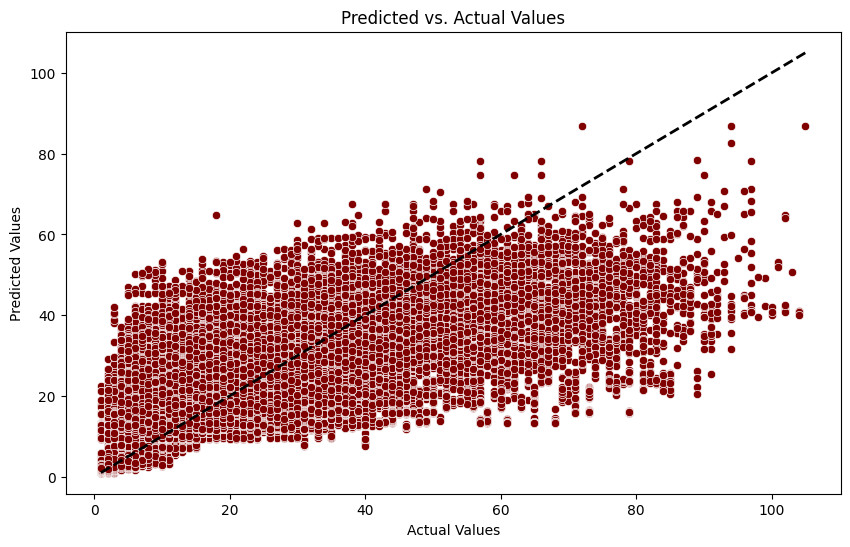

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, c = 'maroon')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  
plt.show()



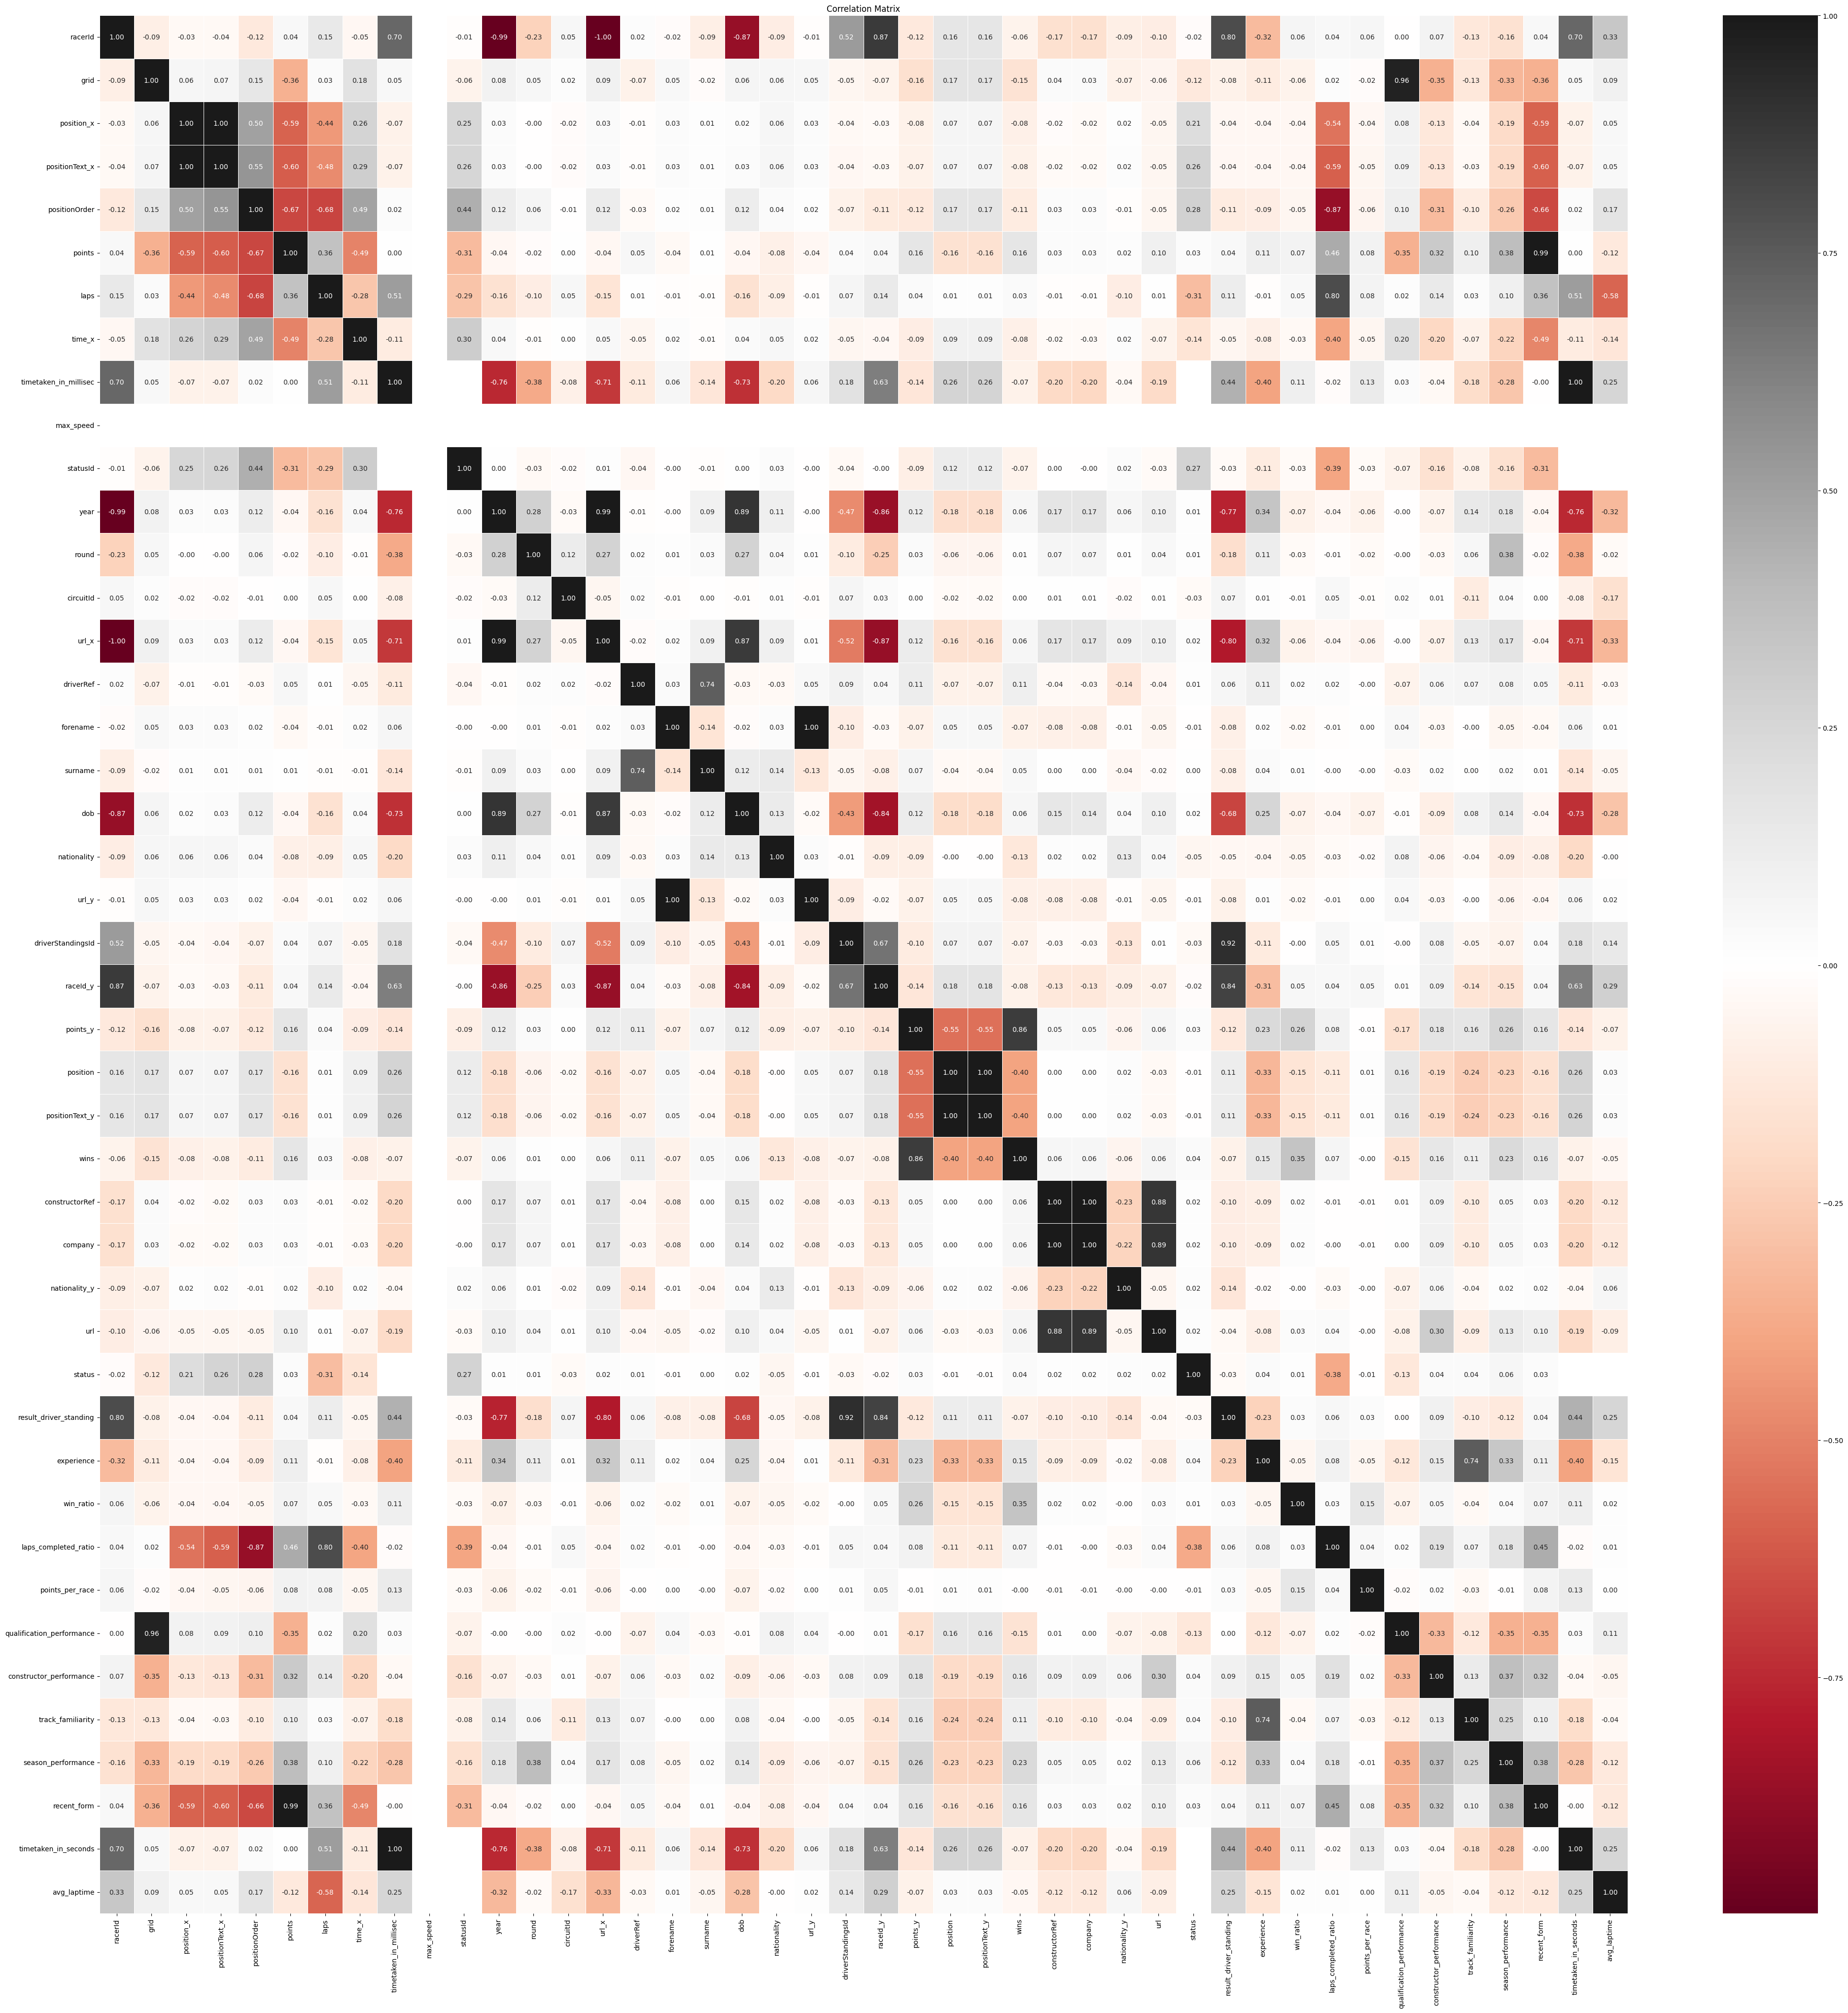

In [88]:
corr = df.corr()

cmap = sns.light_palette("red", as_cmap=True)
plt.figure(figsize=(50, 50))
sns.heatmap(corr, annot=True, cmap='RdGy', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [89]:
g = sns.pairplot(df[['grid', 'positionOrder', 'points', 'laps']], 
                 plot_kws={'color': 'maroon'}, 
                 diag_kws={'color': 'grey'})

plt.show()

KeyboardInterrupt: 

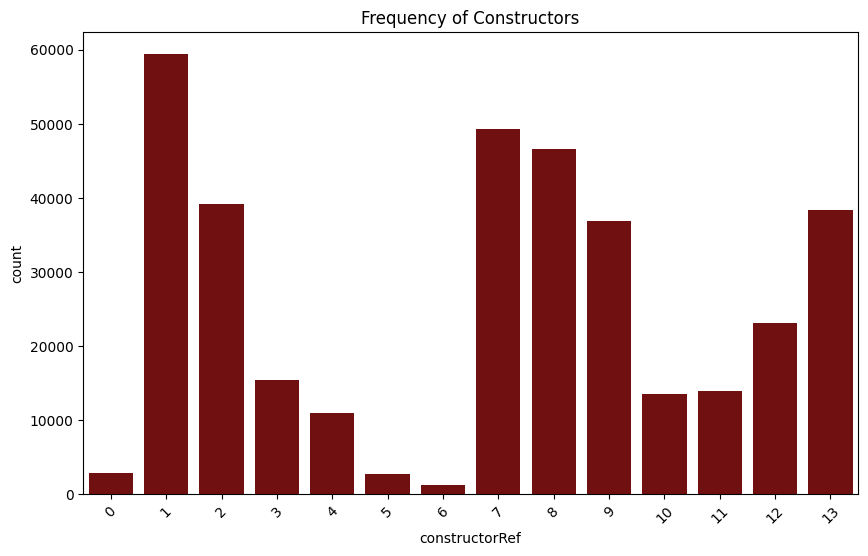

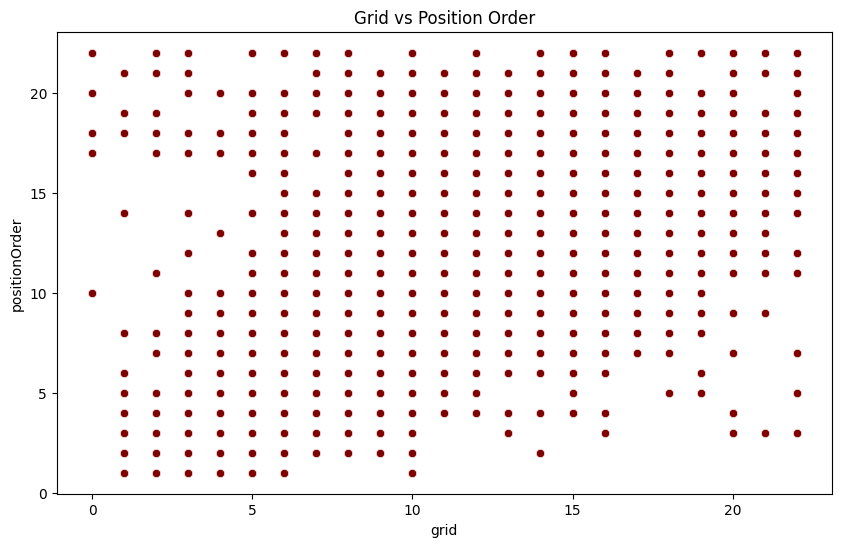

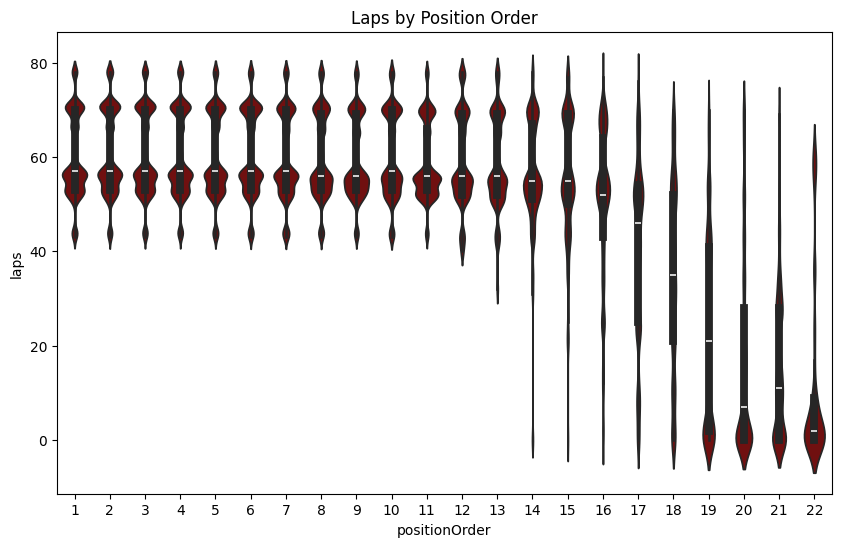

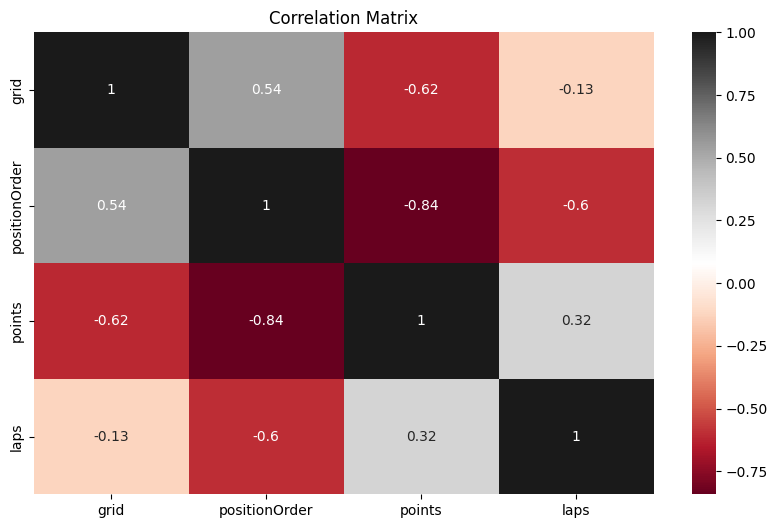

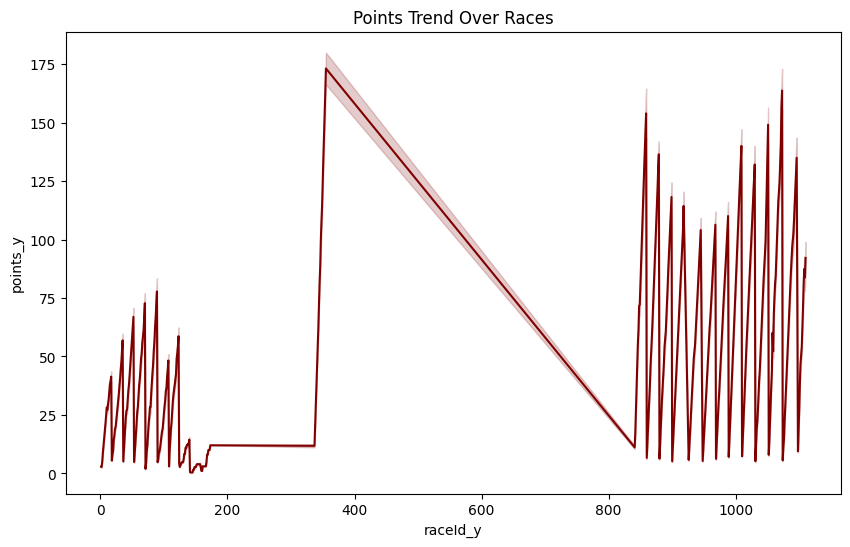

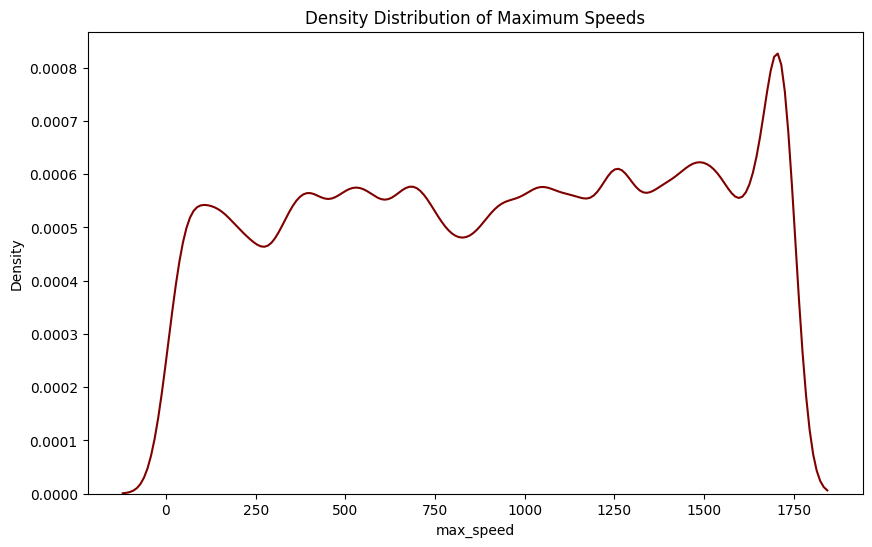

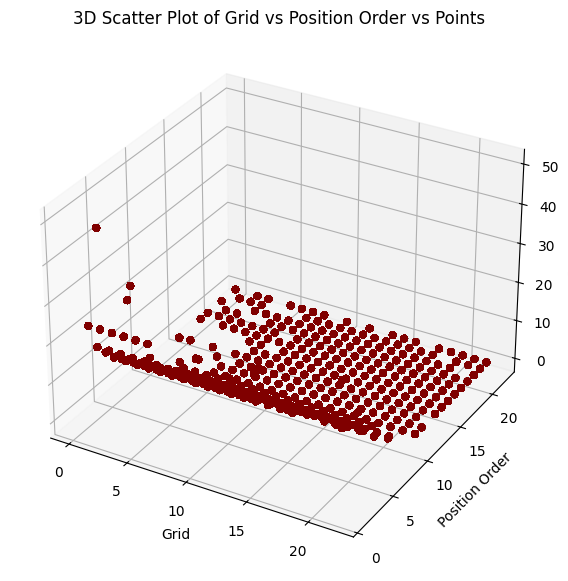

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(10, 6))
sns.countplot(x='constructorRef', data=df, color='maroon')
plt.title('Frequency of Constructors')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='grid', y='positionOrder', data=df, color='maroon')
plt.title('Grid vs Position Order')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='positionOrder', y='laps', data=df, color='maroon')
plt.title('Laps by Position Order')
plt.show()



plt.figure(figsize=(10, 6))
sns.heatmap(df[['grid', 'positionOrder', 'points', 'laps']].corr(), annot=True,cmap='RdGy')
plt.title('Correlation Matrix')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='raceId_y', y='points_y', data=df, color='maroon')
plt.title('Points Trend Over Races')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['max_speed'], color='maroon')
plt.title('Density Distribution of Maximum Speeds')
plt.show()

# 3D Visualizations
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['grid'], df['positionOrder'], df['points'],c='maroon')
ax.set_xlabel('Grid')
ax.set_ylabel('Position Order')
ax.set_zlabel('Points')
plt.title('3D Scatter Plot of Grid vs Position Order vs Points')
plt.show()


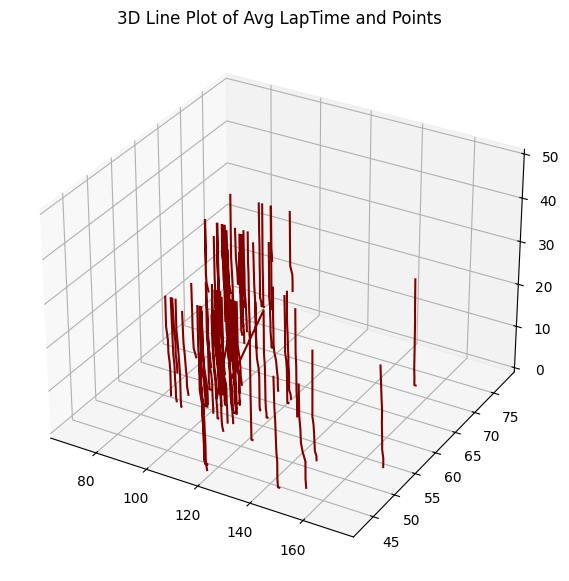

In [ ]:

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(df['avg_laptime'], df['laps'], df['points'], 'maroon')  
plt.title('3D Line Plot of Avg LapTime and Points')
plt.show()